# Proyecto Sprint 13

## Descripción del proyecto

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado. A Rusty Bargain le interesa:

- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Descripción de los datos

Características

- DateCrawled — fecha en la que se descargó el perfil de la base de datos
- VehicleType — tipo de carrocería del vehículo
- RegistrationYear — año de matriculación del vehículo
- Gearbox — tipo de caja de cambios
- Power — potencia (CV)
- Model — modelo del vehículo
- Mileage — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- RegistrationMonth — mes de matriculación del vehículo
- FuelType — tipo de combustible
- Brand — marca del vehículo
- NotRepaired — vehículo con o sin reparación
- DateCreated — fecha de creación del perfil
- NumberOfPictures — número de fotos del vehículo
- PostalCode — código postal del propietario del perfil (usuario)
- LastSeen — fecha de la última vez que el usuario estuvo activo

Objetivo

- Price — precio (en euros)

## Objetivos del proyecto

1. Hacer prueba de cordura con regresión lineal
2. Optimizar los hiperparametros de un modelo de:
    1. Bosque aleatorio
    2. Potenciación de gradiente usando LightGBM y Catboost
3. Evaluar los modelos con la métrica RECM


## Importar librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Preparación de los datos

### Exploración inicial de los datos

In [2]:
data = pd.read_csv('car_data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
data.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


<span style=color:blue>**Comentario**</span>

- Hay datos ausentes en varias columnas categóricas:
    - VehicleType
    - Gearbox
    - Model
    - FuelType
    - NotRepaired
- Considero que las columnas DateCrawled, DateCreated, RegistrationMonth, PostalCode y LastSeen no aportan información valiosa para la predicción, por lo que las eliminaré.
- Todos los valores de la columna NumberOfPictures son 0, tampoco aporta valor.
- Hay autos con precio de venta de 0
- Hay años de registro sin sentido, como año 1000 o 9999
- Hay autos con potencia de 0

### Exploración de datos duplicados

In [5]:
data.duplicated().sum()

262

In [6]:
# Eliminación de duplicados
data.drop_duplicates(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354107 non-null  object
 1   Price              354107 non-null  int64 
 2   VehicleType        316623 non-null  object
 3   RegistrationYear   354107 non-null  int64 
 4   Gearbox            334277 non-null  object
 5   Power              354107 non-null  int64 
 6   Model              334406 non-null  object
 7   Mileage            354107 non-null  int64 
 8   RegistrationMonth  354107 non-null  int64 
 9   FuelType           321218 non-null  object
 10  Brand              354107 non-null  object
 11  NotRepaired        282962 non-null  object
 12  DateCreated        354107 non-null  object
 13  NumberOfPictures   354107 non-null  int64 
 14  PostalCode         354107 non-null  int64 
 15  LastSeen           354107 non-null  object
dtypes: int64(7), object(9)
me

### Eliminación de columnas no valiosas para el modelo

In [7]:
columns_drop = ['DateCrawled', 'DateCreated', 'RegistrationMonth',
                'NumberOfPictures', 'PostalCode', 'LastSeen']



data_1 = data.drop(columns=columns_drop)


data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354107 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354107 non-null  int64 
 1   VehicleType       316623 non-null  object
 2   RegistrationYear  354107 non-null  int64 
 3   Gearbox           334277 non-null  object
 4   Power             354107 non-null  int64 
 5   Model             334406 non-null  object
 6   Mileage           354107 non-null  int64 
 7   FuelType          321218 non-null  object
 8   Brand             354107 non-null  object
 9   NotRepaired       282962 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


In [8]:
data_1.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Exploración de datos ausentes

In [9]:
data_1.isna().sum()

Price                   0
VehicleType         37484
RegistrationYear        0
Gearbox             19830
Power                   0
Model               19701
Mileage                 0
FuelType            32889
Brand                   0
NotRepaired         71145
dtype: int64

In [10]:
# Filtro para encontrar los valores ausentes simultaneos en todas las columnas
data_na = data_1.query(
    'VehicleType.isna() and Gearbox.isna() and Model.isna() and FuelType.isna() and NotRepaired.isna()')

In [11]:
data_na.describe()

,Price,RegistrationYear,Power,Mileage
count,2236.000000,2236.000000,2236.000000,2236.000000
mean,1129.788909,2061.372987,11.595259,92468.694097
std,2474.074364,707.515655,48.905372,64987.945220
min,0.000000,1000.000000,0.000000,5000.000000
25%,0.000000,1995.000000,0.000000,5000.000000
50%,200.000000,2000.000000,0.000000,125000.000000
75%,1000.000000,2005.000000,0.000000,150000.000000
max,20000.000000,9999.000000,1000.000000,150000.000000


<span style=color:blue>**Comentario**</span>

- Hay 2236 filas con valores ausentes en todas las columnas categóricas simultáneamente. 
- Las eliminaré del dataframe.

In [12]:
# Eliminación de las 2236 filas con valores ausentes
delete_row = data_na.index

data_1.drop(delete_row, inplace=True)

In [13]:
data_1.isna().sum()

Price                   0
VehicleType         35248
RegistrationYear        0
Gearbox             17594
Power                   0
Model               17465
Mileage                 0
FuelType            30653
Brand                   0
NotRepaired         68909
dtype: int64

#### Exploración de columnas categóricas con datos ausentes

In [14]:
# Conteo de valores únicos en el dataframe
data_1['VehicleType'].value_counts(dropna=False)

VehicleType
sedan          91399
small          79753
wagon          65115
NaN            35248
bus            28752
convertible    20180
coupe          16147
suv            11991
other           3286
Name: count, dtype: int64

In [15]:
# Agrupación por tipo de vehiculo y precio promedio
data_1.groupby('VehicleType', dropna=False)['Price'].mean()

VehicleType
bus            5486.293127
convertible    6806.707582
coupe          6010.048430
other          3563.024954
sedan          4722.808247
small          2677.227402
suv            9009.410725
wagon          4880.275298
NaN            2454.672180
Name: Price, dtype: float64

<span style=color:blue>**Comentario**</span>

- El tipo de vehiculo "other" ocupa el cuarto lugar en el ranking de precios promedio, mientras que los autos sin tipo ocupan el último lugar.
- Convertiré todos los valores NaN de esta columna en 'other' 

In [16]:
# Conteo de valores unicos en columna Gearbox
data_1['Gearbox'].value_counts(dropna=False)

Gearbox
manual    268034
auto       66243
NaN        17594
Name: count, dtype: int64

<span style=color:blue>**Comentario**</span>

- Los valores ausentes en esta categoría podrían ser autos que combinan ambos tipo de maquinaria.
- Cambiaré los valores ausentes a "other"

In [17]:
# conteo de valores únicos en modelos
data_1['Model'].value_counts(dropna=False)

Model
golf                  29215
other                 24402
3er                   19744
NaN                   17465
polo                  13057
                      ...  
i3                        8
serie_3                   4
rangerover                4
range_rover_evoque        2
serie_1                   2
Name: count, Length: 251, dtype: int64

In [18]:
# Agrupación por modelo de vehiculo y precio promedio
model_price = data_1.groupby('Model', dropna=False)['Price'].mean()

In [19]:
model_price.reset_index().query('Model == "other" or Model.isna()')

,Model,Price
166,other,4417.218589
250,NaN,3156.892184


<span style=color:blue>**Comentario**</span>

- El modelo de vehiculo "other" ocupa el segundo lugar en el conteo de registros de autos, sin embargo es la posición 167 en precio promedio.
- Los autos con modelos ausente, ocupan el último lugar en precio promedio.
- Convertiré los valores ausentes a "other"

In [20]:
# Conteo de valores únicos en tipo de combustible
data_1['FuelType'].value_counts(dropna=False)

FuelType
petrol      216161
gasoline     98658
NaN          30653
lpg           5307
cng            565
hybrid         233
other          204
electric        90
Name: count, dtype: int64

In [21]:
# Agrupación por tipo de combustible y precio promedio
data_1.groupby('FuelType', dropna=False)['Price'].mean()

FuelType
cng         4464.661947
electric    6657.711111
gasoline    6580.017647
hybrid      9465.356223
lpg         4040.142830
other       2312.029412
petrol      3749.546232
NaN         2428.696767
Name: Price, dtype: float64

<span style=color:blue>**Comentario**</span>

- El tipo de combustible "other" y los ausentes, están en las últimas posiciones de precios promedios.
- Convertiré los valores ausentes en "other"

In [22]:
# Conteo de valores unicos en columna de reparaciones
data_1['NotRepaired'].value_counts(dropna=False)

NotRepaired
no     246927
NaN     68909
yes     36035
Name: count, dtype: int64

In [23]:
# Agrupación por reparaciones y precio promedio
data_1.groupby('NotRepaired', dropna=False)['Price'].mean()

NotRepaired
no     5297.025526
yes    1916.151131
NaN    2675.073009
Name: Price, dtype: float64

<span style=color:blue>**Comentario**</span>

- El precio promedio de los autos con ausencia de datos de reparación es mayor que el de aquellos que reportaron una reparación, por lo que asumiré que se trata de autos sin reparación.
- Cambiaré los valores ausentes por "no"

#### Ajuste de valores ausentes 

In [24]:
# Cambio de NaN a "other" en VehicleType
data_1.fillna({'VehicleType': 'other'}, inplace=True)

In [25]:
# Cambio de NaN a "other" en Gearbox
data_1.fillna({'Gearbox': 'other'}, inplace=True)

In [26]:
# Cambio de NaN a "other" en Model
data_1.fillna({'Model': 'other'}, inplace=True)

In [27]:
# Cambio de NaN a "other" en FuelType
data_1.fillna({'FuelType': 'other'}, inplace=True)

In [28]:
# Cambio de NaN a "no" en NotRepaired
data_1.fillna({'NotRepaired': 'no'}, inplace=True)

In [29]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 351871 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             351871 non-null  int64 
 1   VehicleType       351871 non-null  object
 2   RegistrationYear  351871 non-null  int64 
 3   Gearbox           351871 non-null  object
 4   Power             351871 non-null  int64 
 5   Model             351871 non-null  object
 6   Mileage           351871 non-null  int64 
 7   FuelType          351871 non-null  object
 8   Brand             351871 non-null  object
 9   NotRepaired       351871 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.5+ MB


### Exploración de valores con precios, año de registro y potencias inverosímiles

In [30]:
data_1.describe()

,Price,RegistrationYear,Power,Mileage
count,351871.000000,351871.000000,351871.000000,351871.000000
mean,4437.318603,2003.872269,110.715543,128438.944954
std,4516.724116,70.699431,190.314641,37563.868483
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


<Axes: ylabel='Price'>

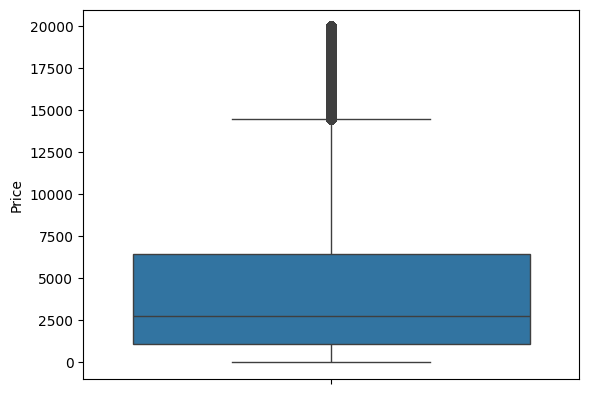

In [31]:
# Diagrama de caja para los precios
sns.boxplot(data=data_1['Price'])

<span style=color:blue>**Comentario**</span>

- Los valores atípicos comienzan cercanos a $15000

(1985.0, 2020.0)

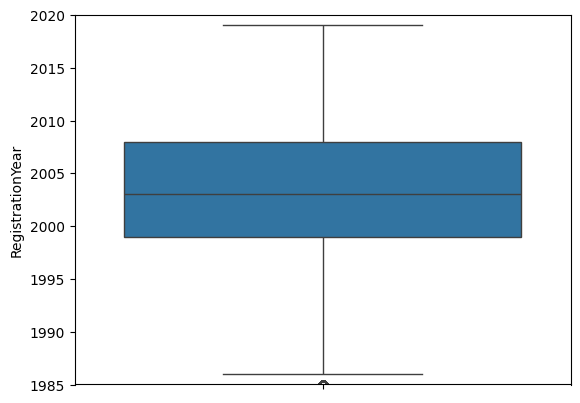

In [32]:
# Diagrama de caja para los años de registro, ajustando los ejes para mostrar cercano al periodo 1985 - 2020
sns.boxplot(data=data_1['RegistrationYear'])
plt.ylim(1985, 2020)

<span style=color:blue>**Comentario**</span>

- Los valores atípicos comienzan por arriba del año 2020 y por debajo del año 1985

(-5.0, 280.0)

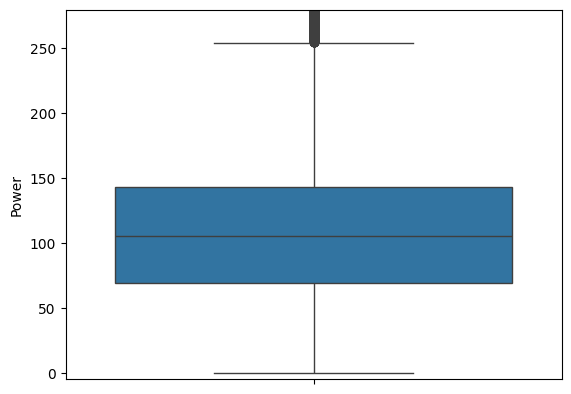

In [33]:
# Diagrama de caja para las potencias, ajustado el eje hasta 280 CV
sns.boxplot(data=data_1['Power'])
plt.ylim(-5, 280)

<span style=color:blue>**Comentario**</span>

- Los valores atípicos comienzan por arriba de 250 CV aproximadamente.

In [34]:
# Proporción de atípicos en el dataset

# Atípicos en precio
p = 100 * data_1.query('Price > 15000').shape[0]/len(data_1)
# Atípicos en año de registro
yr = 100 * \
    data_1.query(
        'RegistrationYear < 1985 or RegistrationYear > 2020').shape[0]/len(data_1)
# Atípicos en potencia
pw = 100 * data_1.query('Power > 250').shape[0]/len(data_1)

out = {'Categoría': ['Price', 'RegistrationYear', 'Power'],
       '%': [p, yr, pw]}

print('Proporción de atípicos en el dataset original')
pd.DataFrame(out)

Proporción de atípicos en el dataset original


,Categoría,%
0,Price,4.222002
1,RegistrationYear,1.504529
2,Power,2.113274


<span style=color:blue>**Comentario**</span>

- Los valores atípicos representan cerca del 8% de los datos totales.

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'RegistrationYear'}>],
       [<Axes: title={'center': 'Power'}>,
        <Axes: title={'center': 'Mileage'}>]], dtype=object)

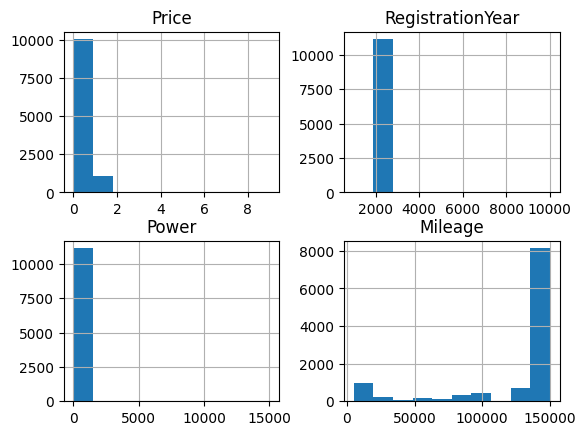

In [35]:
# Exploración de precios en 0 y menores a 10
data_1.query('Price < 10').hist()

<span style=color:blue>**Comentario**</span>

- Hay mayor cantidad de autos con precios de $0 que con precios de $1, el kilometraje principalmente es cercano a 150,000 km y al año de registro es cercano a los 2000.

<Axes: ylabel='Mileage'>

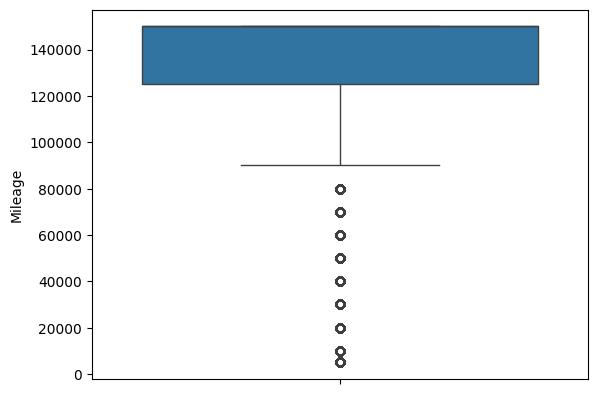

In [36]:
# Disctribución de kilometraje
sns.boxplot(data_1['Mileage'])

<span style=color:blue>**Comentario**</span>

- Los valores atípicos de kilometraje comienzan por debajo de 90000 km aproximadamente.

In [37]:
# Autos con precios de $0
data_1.query('Price == 0').value_counts().head()

Price  VehicleType  RegistrationYear  Gearbox  Power  Model   Mileage  FuelType  Brand       NotRepaired
0      sedan        1997              manual   75     golf    150000   petrol    volkswagen  no             61
                    1998              manual   60     golf    150000   petrol    volkswagen  no             18
       small        2012              manual   90     rio     90000    gasoline  kia         no             18
       other        2000              other    0      golf    150000   other     volkswagen  no             15
       bus          2005              manual   101    vivaro  80000    gasoline  opel        no             15
Name: count, dtype: int64

In [38]:
# Autos con precios de $1
data_1.query('Price == 1').value_counts().head()

Price  VehicleType  RegistrationYear  Gearbox  Power  Model  Mileage  FuelType  Brand       NotRepaired
1      wagon        1998              manual   136    omega  150000   petrol    opel        no             6
       other        2000              other    0      polo   150000   other     volkswagen  no             4
       small        1999              manual   115    golf   150000   petrol    volkswagen  no             4
       wagon        2006              manual   150    3er    150000   petrol    bmw         no             4
                    2007              auto     200    3er    150000   gasoline  bmw         no             4
Name: count, dtype: int64

<span style=color:blue>**Comentario**</span>

- Los precios menores a $1 coinciden principalmente con autos de transmisión manual, combustible petrol y kilometraje de 150,000 km.
- Usaré el promedio de precio de los autos con estas características para cambiar todos los precios menores de $1.

In [39]:
# Exploración de potencias iguales a 0
data_1.query('Power == 0').value_counts().head()

Price  VehicleType  RegistrationYear  Gearbox  Power  Model   Mileage  FuelType  Brand       NotRepaired
2600   small        2004              other    0      golf    150000   gasoline  volkswagen  no             46
3000   sedan        2004              other    0      3er     150000   gasoline  bmw         no             29
2700   wagon        2004              other    0      sharan  150000   gasoline  volkswagen  no             24
2600   wagon        2005              other    0      zafira  150000   gasoline  opel        no             23
2100   small        2002              other    0      a4      150000   gasoline  audi        no             21
Name: count, dtype: int64

<span style=color:blue>**Comentario**</span>

- Los autos con potencia de 0, coinciden princicplamente con autos registrados por arriba del 2003, transmisión "other", 150,000 km y gasolina como combustible.
- Usaré el promedio de la potencia de autos con estas características.

#### Ajuste de precios menores a $1

In [40]:
# Promedio de precio de autos con transmisión manual, combustible petrol y 150,000 km
avg = data_1.query(
    'Gearbox == "manual" and FuelType == "petrol" and Mileage == 150000')['Price'].mean()

avg

2029.738512601468

In [41]:
# Cambio de valores 0 y 1 por el promedio encontrado
data_1['Price'] = data_1['Price'].replace([0, 1], [avg, avg])

data_1.describe()

,Price,RegistrationYear,Power,Mileage
count,351871.000000,351871.000000,351871.000000,351871.000000
mean,4501.402661,2003.872269,110.715543,128438.944954
std,4467.442894,70.699431,190.314641,37563.868483
min,2.000000,1000.000000,0.000000,5000.000000
25%,1250.000000,1999.000000,69.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Ajuste de potencias iguales a 0

In [42]:
# Promedio de potencia de autos registrados después del 2003, con transmisión "other", combustible gasolina y 150,000 km
avg_pw = data_1.query(
    'RegistrationYear > 2003 and Gearbox == "other" and FuelType == "gasoline" and Mileage == 150000')['Power'].mean()

avg_pw

37.30834114339269

In [43]:
# Cambio de valores 0 por el promedio encontrado
data_1['Power'] = data_1['Power'].replace(0, avg_pw)

data_1.describe()

,Price,RegistrationYear,Power,Mileage
count,351871.000000,351871.000000,351871.000000,351871.000000
mean,4501.402661,2003.872269,114.765619,128438.944954
std,4467.442894,70.699431,188.301743,37563.868483
min,2.000000,1000.000000,1.000000,5000.000000
25%,1250.000000,1999.000000,69.000000,125000.000000
50%,2750.000000,2003.000000,105.000000,150000.000000
75%,6450.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


#### Ajuste de valores atípicos

In [44]:
# Eliminando atípicos de precio (por arriba de $15,000)
data_1 = data_1.query('Price < 15000')

In [45]:
# Eliminando atípicos de año de registro (seleccionando solo el periodo 1985 a 2020)
data_1 = data_1.query('1985 < RegistrationYear < 2020')

In [46]:
# Eliminando atípicos de potencia (por arriba de 250 CV)
data_1 = data_1.query('Power <= 250')

In [47]:
# Eliminando atípicos de kilometraje (por debajo de 90,000 km)
data_1 = data_1.query('Mileage >= 90000')

In [48]:
len(data_1) / len(data)

0.7993939684897503

<span style=color:blue>**Comentario**</span>

- El dataframe final, después de la eliminación de atípicos y ajuste de datos en 0, mantiene el 80% de la cantidad de datos originales.

## Ingeniería de datos

### Separar atributos y target

In [49]:
X = data_1.drop(columns='Price')  # Atributos
y = data_1['Price']  # Target

print(X.shape)
print(y.shape)

(283071, 9)
(283071,)


### Estudiar normalidad del target

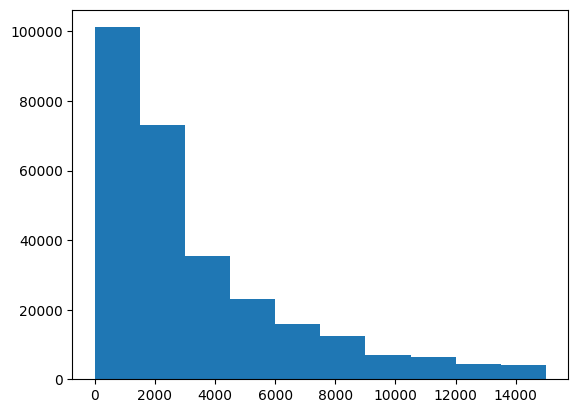

In [50]:
plt.hist(y)
plt.show()

<span style=color:blue>**Comentario**</span>

- La distribución de los precios está mayormente sesgada a la derecha

In [51]:
# Reescalamiento de la variable target con logaritmos
y = np.log(y + 1)

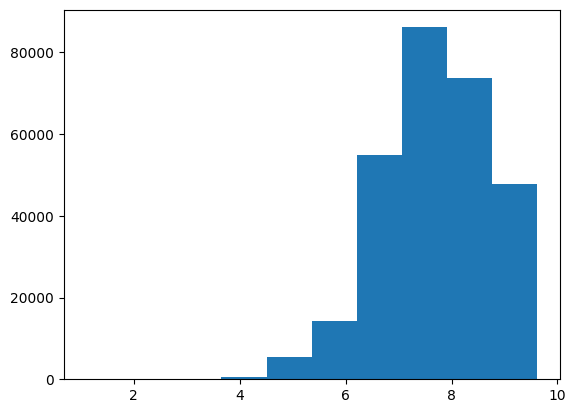

In [52]:
plt.hist(y)
plt.show()

<span style=color:blue>**Comentario**</span>

- La distribución de los precios es ahora más parecida a una distribución normal.

### Codificación OHE

In [53]:
X.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,other,1993,manual,37.308341,golf,150000,petrol,volkswagen,no
2,suv,2004,auto,163.000000,grand,125000,gasoline,jeep,no
3,small,2001,manual,75.000000,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69.000000,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102.000000,3er,150000,petrol,bmw,yes


In [54]:
# Codificación OHE
X = pd.get_dummies(X, drop_first=True)
X = X.astype(int)  # convertir boleanos en numeros
X.head()

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
0,1993,37,150000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
5,1995,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Partición de datos

In [55]:
# Creación de sets de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=12345)

print(X_train.shape)
print(X_test.shape)

(212303, 302)
(70768, 302)


### Escalamiento de atributos numéricos

In [56]:
# Variables a escalar
var_num = ['RegistrationYear', 'Power', 'Mileage']

# Ajuste de modelo para escalar
scaler = StandardScaler().fit(X_train[var_num])

In [57]:
# Escalar los atributos en entrenamiento y prueba
X_train[var_num] = scaler.transform(X_train[var_num])
X_test[var_num] = scaler.transform(X_test[var_num])

X_train.sample(5)

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
241771,0.207539,1.424504,0.456502,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88858,-0.447583,2.383115,0.456502,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
127530,2.336688,-0.961827,-2.627869,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
326672,0.862662,-0.615096,0.456502,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
59027,-0.775144,0.873812,0.456502,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
X_train.describe().round(4)

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_yes
count,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,...,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000,212303.0000
mean,-0.0000,0.0000,0.0000,0.0504,0.0412,0.1127,0.2618,0.2189,0.0272,0.2024,...,0.0139,0.0115,0.0036,0.0022,0.0055,0.0121,0.0002,0.2263,0.0099,0.1127
std,1.0000,1.0000,1.0000,0.2188,0.1986,0.3162,0.4396,0.4135,0.1627,0.4018,...,0.1172,0.1067,0.0600,0.0465,0.0739,0.1095,0.0142,0.4184,0.0992,0.3162
min,-2.7405,-2.1652,-3.2447,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,-0.6114,-0.7783,0.4565,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,-0.1200,-0.0848,0.4565,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,0.5351,0.6699,0.4565,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,2.6642,2.9134,0.4565,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<span style=color:blue>**Comentario**</span>

- Después del escalamiento, los valores de promedio y desviación estándar son los esperados.

## Prueba de cordura: regresión lineal tradicional

In [59]:
# Función para métricas r2 y RECM

def metricas(y_test, y_pred, imprimir=False):
    r2 = r2_score(y_test, y_pred)
    RECM = mean_squared_error(y_test, y_pred)**0.5

    if imprimir == True:
        print(f'r2: {r2:.1%}')
        print(f'RECM: {RECM:.2}')

    return r2, RECM

In [60]:
# Selección y ajuste de modelo de regresión lineal
mod_reg = LinearRegression().fit(X_train, y_train)

# Predicción
y_pred = mod_reg.predict(X_test)

In [61]:
# Métricas
r2_reg, RECM_reg = metricas(y_test, y_pred, imprimir=True)

r2: 66.1%
RECM: 0.61


## Regresión con árbol de decisión

In [62]:
# Creación del modelo
tree_reg = DecisionTreeRegressor(random_state=12345).fit(X_train, y_train)

# Predicción
y_pred = tree_reg.predict(X_test)

In [63]:
# Métricas
r2_tree, RECM_tree = metricas(y_test, y_pred, imprimir=True)

r2: 66.8%
RECM: 0.6


### Ajuste de hiperparámetros

In [64]:
# Crear un modelo de árbol de decisión
model = DecisionTreeRegressor(random_state=12345)

# Crear un diccionario con los hiperparámetros a ajustar
param_grid = {'max_depth': [2, 5, 10],
              'min_samples_split': [2, 5, 10]}

# Realizar una búsqueda en cuadrícula utilizando validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
best_params

{'max_depth': 10, 'min_samples_split': 10}

In [65]:
# Creación del modelo con los hiperparámetros seleccionados
tree_reg_2 = DecisionTreeRegressor(
    max_depth=10, min_samples_split=10, random_state=12345)

# Ajuste del modelo
tree_reg_2.fit(X_train, y_train)

# Predicción
y_pred = tree_reg_2.predict(X_test)

In [66]:
# Métricas
r2_tree_2, RECM_tree_2 = metricas(y_test, y_pred, imprimir=True)

r2: 69.4%
RECM: 0.57


## Regresión con bosque aleatorio

In [67]:
# Selección y ajuste del modelo
forest_reg = RandomForestRegressor(random_state=12345).fit(X_train, y_train)

# Predicción
y_pred = forest_reg.predict(X_test)

In [68]:
# Métricas
r2_forest, RECM_forest = metricas(y_test, y_pred, imprimir=True)

r2: 74.5%
RECM: 0.52


### Ajuste de hiperparámetros

In [69]:
best_RECM = 1
best_r2 = 0
best_est = 0
best_depth = 0

n_casos = [100, 200, 500]
d_casos = [5, 10, 15, 20]

for n in n_casos:
    for depth in d_casos:
        model = RandomForestRegressor(
            n_estimators=n, max_depth=depth, random_state=12345)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2_forest_h, RECM_forest_h = metricas(y_test, y_pred)

        if RECM_forest_h < best_RECM:
            best_RECM = RECM_forest_h
            best_r2 = r2_forest_h
            best_est = n
            best_depth = depth

print(f"n_estimators: {best_est}, max_depth: {
      best_depth}, r2: {best_r2:.1%}, RECM: {best_RECM:.2}")

n_estimators: 500, max_depth: 20, r2: 75.5%, RECM: 0.51


## Regresión con lightGBM

In [70]:
# Definir y ajustar modelo GBM con valores estándar
mod_gbm = LGBMRegressor(
    verbose=-1,
    random_state=12345,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=0
).fit(X_train, y_train)

# Predicción
y_pred = mod_gbm.predict(X_test)

In [71]:
# Métricas
r2_gbm, RECM_gbm = metricas(y_test, y_pred, imprimir=True)

r2: 75.3%
RECM: 0.52


### Ajuste de hiperparámetros

In [72]:
r_casos = [0.01, 0.05, 0.1, 0.2]  # learning rate
n_casos = [100, 500, 1000]  # estimadores
l1_casos = [0, 0.5, 1]  # regulador alpha
l2_casos = [0, 0.5, 1]  # regulador lambda

In [73]:
best_learning_rate = 0
best_est = 0
best_reg1 = 0
best_reg2 = 0
best_r2 = 0
best_RECM = 1

for r in r_casos:
    for n in n_casos:
        for l1 in l1_casos:
            for l2 in l2_casos:

                mod_gbm = LGBMRegressor(
                    learning_rate=r,
                    n_estimators=n,
                    reg_alpha=l1,
                    reg_lambda=l2,
                    random_state=12345,
                    verbose=-1
                ).fit(X_train, y_train)

                y_pred = mod_gbm.predict(X_test)

                r2_gbm_h, RECM_gbm_h = metricas(y_test, y_pred)

                if RECM_gbm_h < best_RECM:
                    best_RECM = RECM_gbm_h
                    best_r2 = r2_gbm_h
                    best_learning_rate = r
                    best_est = n
                    best_reg1 = l1
                    best_reg2 = l2

print(f"RECM:{best_RECM:.2}, r2:{best_r2:.1%}, learning_rate:{
      best_learning_rate}, estimadores:{best_est}, reg1:{best_reg1}, reg2:{best_reg2}")

RECM:0.5, r2:77.1%, learning_rate:0.2, estimadores:1000, reg1:0.5, reg2:1


## Comparativa de modelos

In [84]:
datos = {'Modelo': ['Regresión_lineal', 'Árbol_de_decisión',
                    'Árbol_de_decisión_ajustado', 'Bosque_aleatorio',
                    'Bosque_aleatorio_ajustado', 'LightGBM', 'LightGBM_ajustado'],
         'r2_score': [r2_reg, r2_tree, r2_tree_2,
                      r2_forest, r2_forest_h, r2_gbm, r2_gbm_h],
         'RECM': [RECM_reg, RECM_tree, RECM_tree_2, RECM_forest,
                  RECM_forest_h, RECM_gbm, RECM_gbm_h],
         'Tiempo_de_ejecución (s)': [4.4, 4.4, 3.0, 4*60+19.8, 96*60+16, 1.4, 3*60+57.4]}

comparativa = pd.DataFrame(datos).sort_values(by='RECM', ascending=True)
comparativa

,Modelo,r2_score,RECM,Tiempo_de_ejecución (s)
6,LightGBM_ajustado,0.770485,0.497928,237.4
4,Bosque_aleatorio_ajustado,0.754866,0.514592,5776.0
5,LightGBM,0.752776,0.516780,1.4
3,Bosque_aleatorio,0.745337,0.524498,259.8
2,Árbol_de_decisión_ajustado,0.693946,0.574990,3.0
1,Árbol_de_decisión,0.668439,0.598470,4.4
0,Regresión_lineal,0.660508,0.605586,4.4


## Conclusiones

1. Se probaron 3 modelos (árbol de decisión, bosque aleatorio y GBM) y 1 como prueba de cordura (regresión lineal).
1. Se midieron los coeficientes r2 en cada modelo y la RECM como métrica principal.
1. Se ajustaron los hiperparámetros de todos los modelos probados.
1. El modelo con el mejor ajuste de los datos, medido con el score r2, fue el modelo con ajuste de hiperparámetros de GBM.
2. El modelo con el error más pequeño, medido con la métrica RECM, fue también el modelo ajustado de GBM.
3. El tiempo de ejecución del modelo ajustado GBM fue de 237.4 s.
3. El modelo sin ajuste de GBM y el bosque aleatorio con ajuste de hiperparámetros obtuvieron una RECM similar, pero el tiempo de ejecución es demasiado elevado para el bosque aleatorio, siendo de 5776 s para este último, y de solo 1.4 s para el primero.
5. La prueba de cordura con el modelo de regresión lineal fue exitosamente superada, pasando de una RECM de 0.605 a 0.497 con el modelo ajustado GBM, lo que representa una optimización del error de 18%.
1. El modelo más adecuado para las necesidades de Rusty Bargain es un modelo GBM con los siguientes hiperparámetros: 
    - learning_rate: 0.2, 
    - estimadores: 1000, 
    - reg1: 0.5, 
    - reg2: 1